In [91]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from datetime import datetime
import xgboost as xgb

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))

    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
TRAIN_DATA_PATH = 'train.csv'
TEST_DATA_PATH = 'test.csv'

In [16]:
class DataPreprocessor:
    def __init__(self):
        self.medians = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min_value = None
        self.max_floor = None
        self.districts_healthcare = None



    def fit(self, df):
        # Medians and quantiles
        self.medians = df.median() # medians
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.999)
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.001)
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03)
        self.max_floor = df['Floor'].max()


        # Compute mean Helthcare_1 value in each district
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        # Life Square fillna
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square']*0.2), inplace=True)


        # Rooms
        # Fillna with medians
        df['Rooms'].fillna(self.medians.Rooms, inplace=True)

        # Compute median room square and fill outliers with LifeSquare/Room_square
        condition_rooms = (df['Rooms'] > 6) | (df['Rooms'] == 0)
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        df.loc[condition_rooms , 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / room_sq

        # Square
        # If LifeSquare > Square: exchange values
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'], df['LifeSquare']))


        # LifeSquare
        # Fill outliers with (Square - KithcenSquare)
        ls_condition = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[ls_condition, 'LifeSquare'] = df.loc[ls_condition, ['Square']] - df.loc[ls_condition, ['KitchenSquare']]


        # KitchenSquare
        # Fill outliers with (Square - LifeSquare - 10% of Square)
        condition_kitchen_square = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare'] < self.kitchen_square_min_value)
        df.loc[condition_kitchen_square, 'KitchenSquare'] = \
            df.loc[condition_kitchen_square, 'Square'] - \
            df.loc[condition_kitchen_square, 'LifeSquare'] - \
            (df.loc[condition_kitchen_square, 'Square'] * 0.1)

        # Ecology and Shops
        # Switch to binary
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)


        # HouseFloor
        # If HouseFloor < Floor: exchange values
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']


        # HouseYear
        # If HouseYear > current year set median value
        current_year = datetime.now().year
        condition_year = (df['HouseYear'] > current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear


        # Healthcare
        # Fillna with dictrict healthcare value. (If district has no healthcare value fill with medians)
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)
        # Clip on upper quantille
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)


        # Drop Id
        #df.drop(['Id'], axis=1, inplace=True)


        # Fillna just in case
        df.fillna(self.medians, inplace=True)
        return df

In [87]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None
        self.Flour_bins = None
        self.Year_bins = None


    def fit(self, df):
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)

        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # median house year in each district
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
                                         / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district

        self.DistrictId_value_counts = dict(df['DistrictId'].value_counts())

        self.Flour_bins = [df['Floor'].min(), 3, 5, 9, 15, df['Floor'].max()]
        self.Year_bins = [df['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, df['HouseYear'].max()]


    def new_features(self, df):

        # DistrictId_counts
        df['DistrictId_counts'] = df['DistrictId'].map(self.DistrictId_value_counts)
        df['DistrictId_counts'].fillna(df['DistrictId_counts'].median(), inplace=True)

        # How old is the district
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Median square of flat in each district
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)

        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Median price for square meter in each district
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)

        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Floor category
        bins = self.Flour_bins
        df['floor_cat'] = pd.cut(df['Floor'], bins=bins, labels=False)
        df['floor_cat'].fillna(-1, inplace=True)

        # Year to cat
        bins = self.Year_bins
        df['year_cat'] = pd.cut(df['HouseYear'], bins=bins, labels=False)
        df['year_cat'].fillna(-1, inplace=True)


        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)

        # Scale and merge Ecology
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        eco_scaled = pd.DataFrame(scaler.fit_transform(df[['Ecology_1', 'Ecology_2', 'Ecology_3']]))
        df['Ecology'] = pca.fit_transform(eco_scaled)


        df.drop(['Id', 'Ecology_3'], axis=1, inplace=True)

        return df


    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]

        return df

In [95]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)

In [96]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>],
       [<AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>],
       [<AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>],
       [<AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

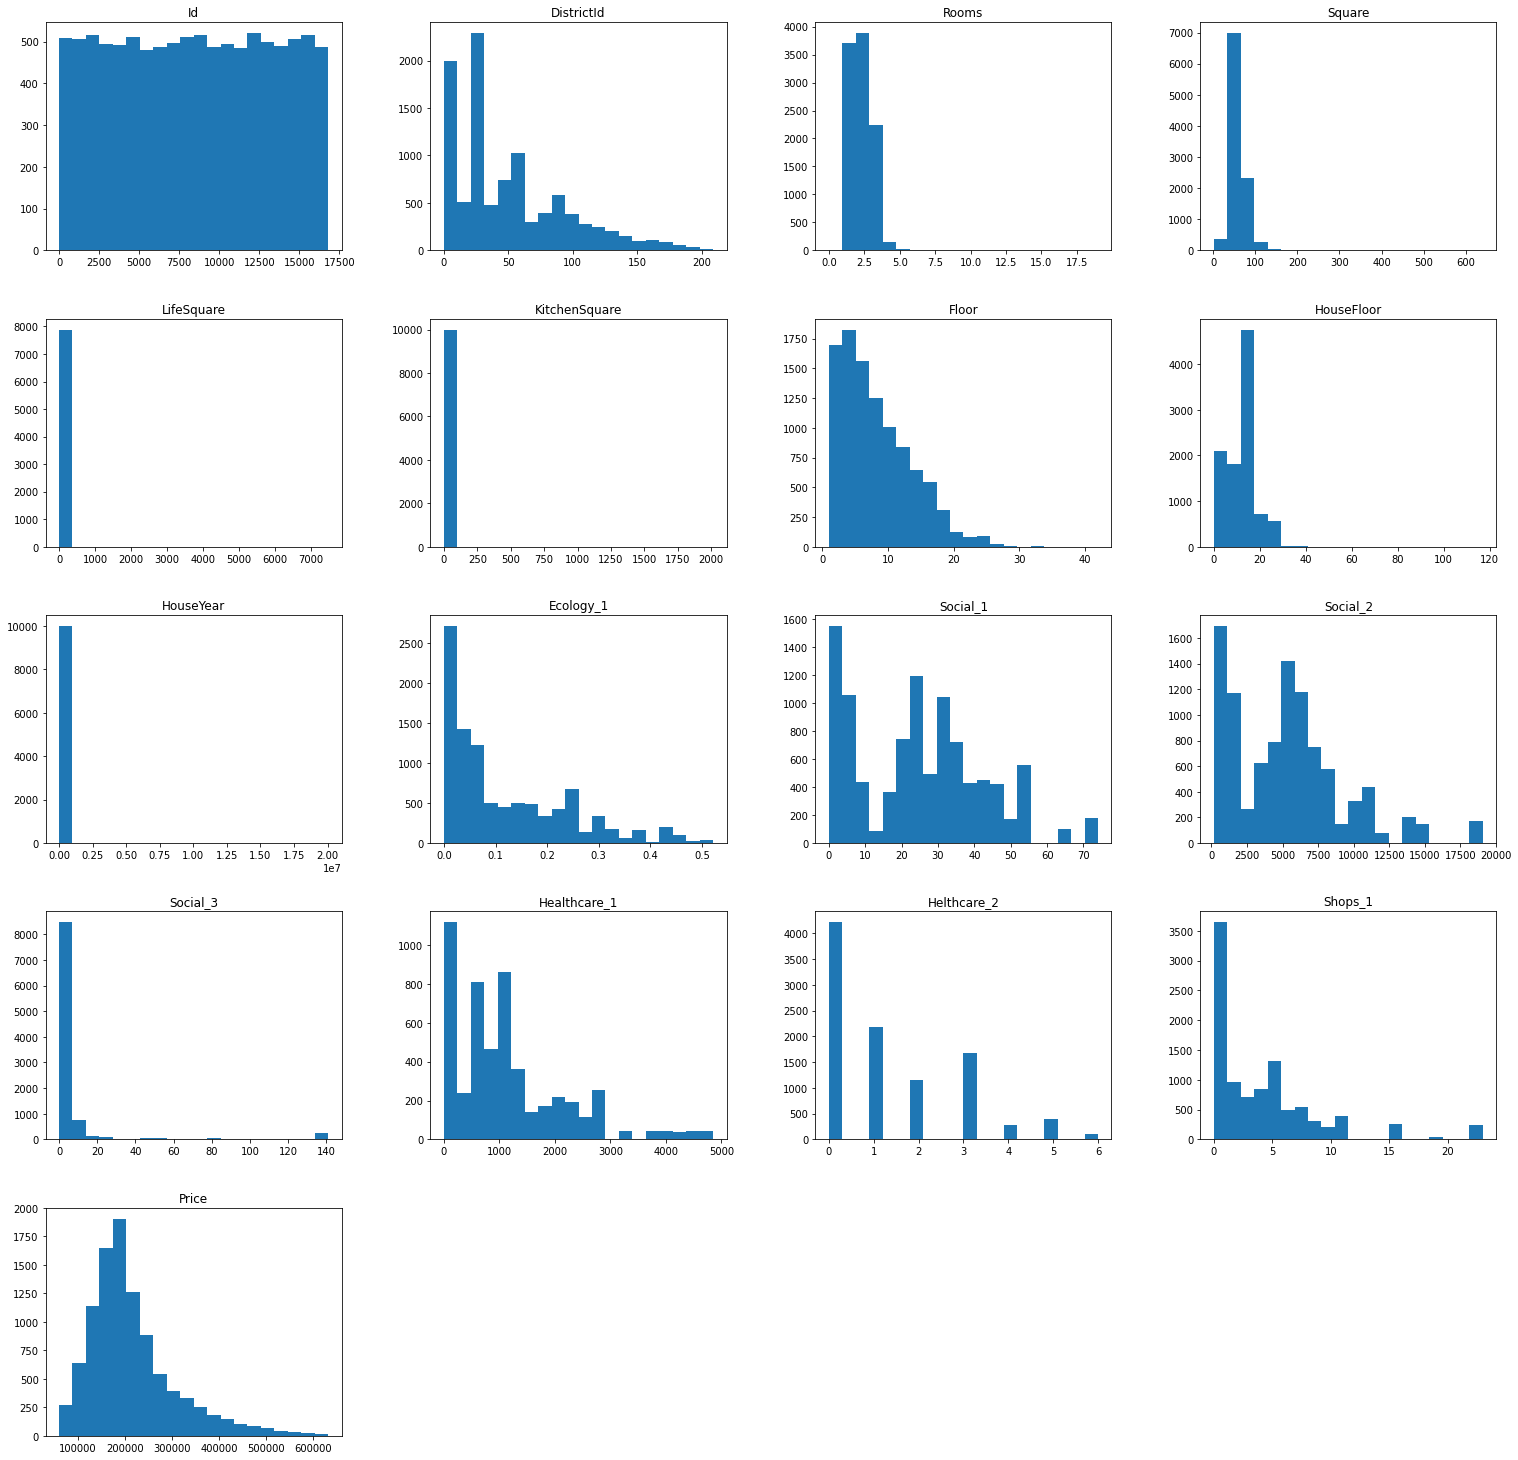

In [103]:
train_df.select_dtypes(include=['float64', 'int64', 'float16']).hist(figsize=(26,26), bins=20, grid=False)

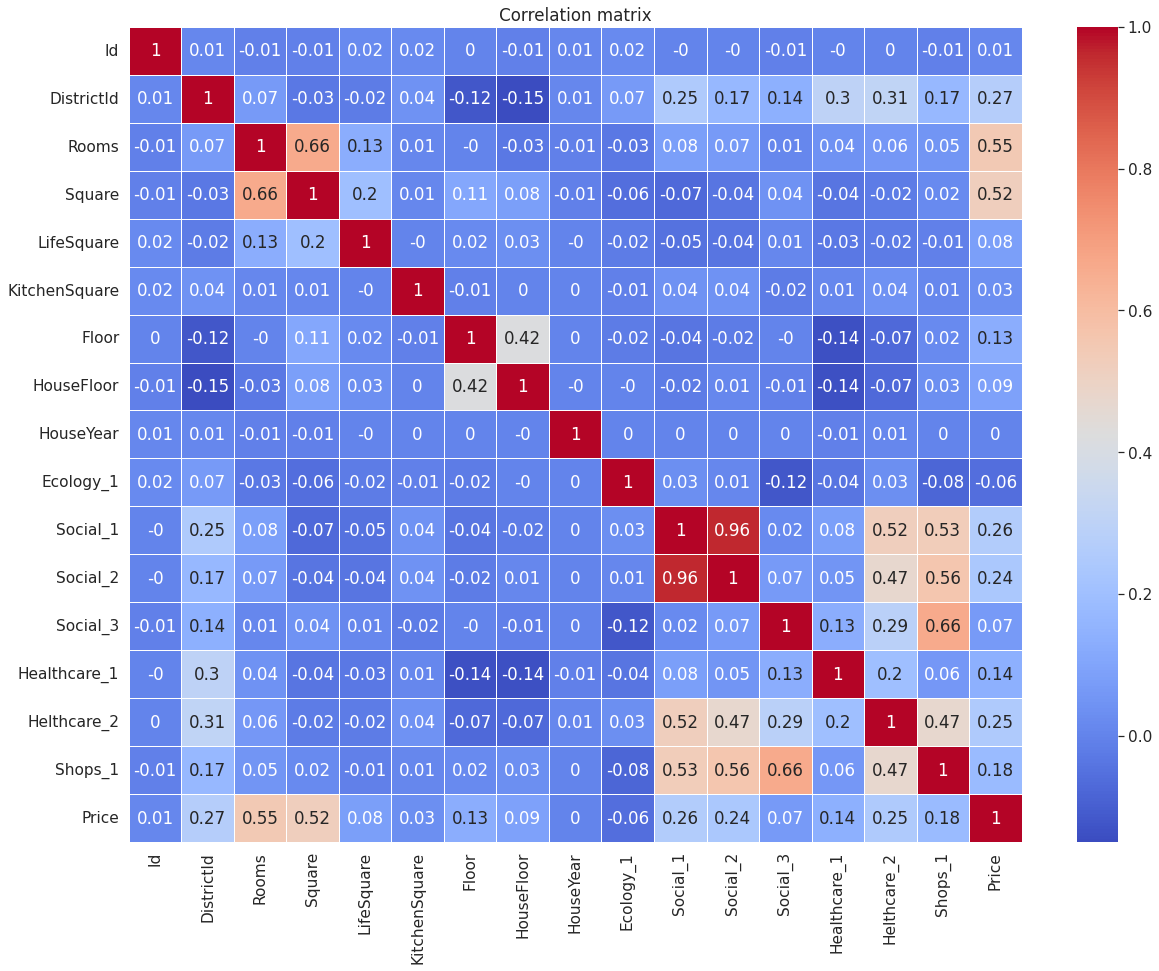

In [104]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)

sns.heatmap(corr_matrix, annot=True, linewidths=1, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [88]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)

preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.new_features(test_df)
#test_df = features_gen.drop_outliers(test_df)

y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.30, random_state=100)

Train R2:	0.9
Test R2:	0.777


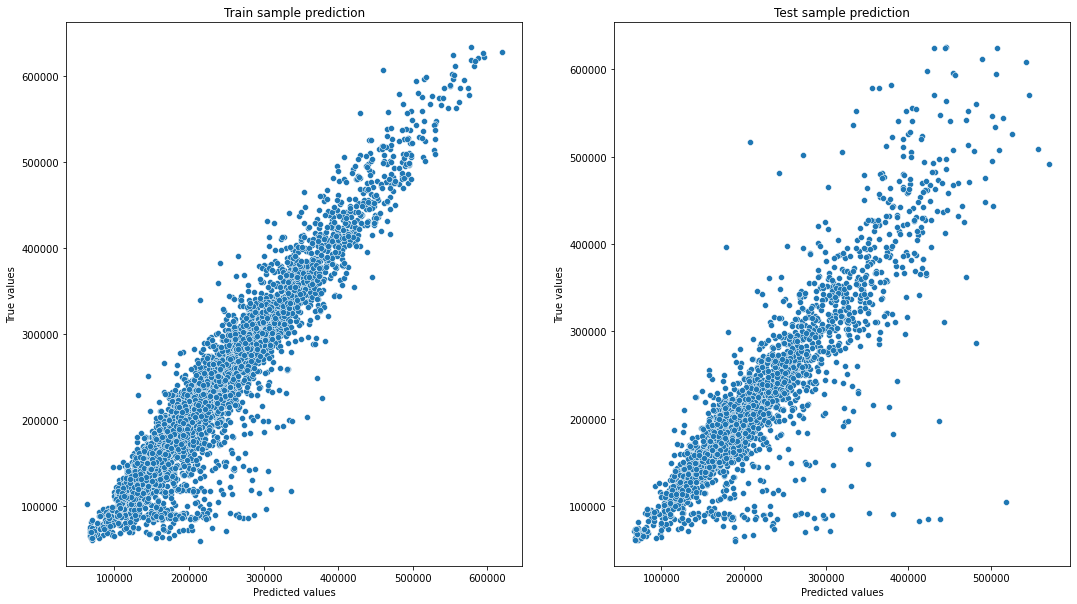

In [89]:
gb_model = xgb.XGBRegressor(colsample_bytree=0.4445,
                            learning_rate=0.01, max_depth=6,
                            min_child_weight=0.1,
                            n_estimators=1000,
                            reg_lambda=0.8,
                            random_state =7)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)


evaluate_preds(y_train.values[:, 0], y_train_preds, y_test.values[:, 0], y_test_preds)

In [90]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
1,Rooms,0.213069
20,DistrictPrice,0.154117
2,Square,0.100941
17,DistrictId_counts,0.078506
23,Social,0.045820
11,Social_2,0.035566
10,Social_1,0.034278
3,LifeSquare,0.034052
4,KitchenSquare,0.031489
12,Social_3,0.030175
